# Loan predictions

## Problem Statement

We want to automate the loan eligibility process based on customer details that are provided as online application forms are being filled. You can find the dataset [here](https://drive.google.com/file/d/1h_jl9xqqqHflI5PsuiQd_soNYxzFfjKw/view?usp=sharing). These details concern the customer's Gender, Marital Status, Education, Number of Dependents, Income, Loan Amount, Credit History and other things as well. 

|Variable| Description|
|: ------------- |:-------------|
|Loan_ID| Unique Loan ID|
|Gender| Male/ Female|
|Married| Applicant married (Y/N)|
|Dependents| Number of dependents|
|Education| Applicant Education (Graduate/ Under Graduate)|
|Self_Employed| Self employed (Y/N)|
|ApplicantIncome| Applicant income|
|CoapplicantIncome| Coapplicant income|
|LoanAmount| Loan amount in thousands|
|Loan_Amount_Term| Term of loan in months|
|Credit_History| credit history meets guidelines|
|Property_Area| Urban/ Semi Urban/ Rural|
|Loan_Status| Loan approved (Y/N)



### Explore the problem in following stages:

1. Hypothesis Generation – understanding the problem better by brainstorming possible factors that can impact the outcome
2. Data Exploration – looking at categorical and continuous feature summaries and making inferences about the data.
3. Data Cleaning – imputing missing values in the data and checking for outliers
4. Feature Engineering – modifying existing variables and creating new ones for analysis
5. Model Building – making predictive models on the data

## 1. Hypothesis Generation

Generating a hypothesis is a major step in the process of analyzing data. This involves understanding the problem and formulating a meaningful hypothesis about what could potentially have a good impact on the outcome. This is done BEFORE looking at the data, and we end up creating a laundry list of the different analyses which we can potentially perform if data is available.

#### Possible hypotheses
Which applicants are more likely to get a loan

1. Applicants having a credit history 
2. Applicants with higher applicant and co-applicant incomes
3. Applicants with higher education level
4. Properties in urban areas with high growth perspectives
5. Larger Loan Amounts have decreased likelyhood of loan approval
6. Difference in Male and Female outcomes?
7. Number of dependants decrease likelyhood of approval
8. The effects of Loan Amount term and approval
9. Properties and loan approval

Do more brainstorming and create some hypotheses of your own. Remember that the data might not be sufficient to test all of these, but forming these enables a better understanding of the problem.

## 2. Data Exploration
Let's do some basic data exploration here and come up with some inferences about the data. Go ahead and try to figure out some irregularities and address them in the next section. 

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings


from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.preprocessing import OrdinalEncoder



from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier

from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from tpot import TPOTClassifier

warnings.filterwarnings('ignore')

df = pd.read_csv("./data.csv") 
df.head()

C:\Users\Jesse\Anaconda3\lib\site-packages\tpot\builtins\__init__.py:36: UserWarning: Warning: optional dependency `torch` is not available. - skipping import of NN models.
  warnings.warn("Warning: optional dependency `torch` is not available. - skipping import of NN models.")


,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [16]:
df.shape

(614, 13)

One of the key challenges in any data set are missing values. Lets start by checking which columns contain missing values.


#### How to fill empty values:
* Gender: Fill empty values with "U"
* Married: Fill Empty with "NO"
* Dependants: Fill 0
* Self Employed: Fill with No
* Loan Amount: Fill with median
* Loan Amount Term: fill with median
* Credit_History: Fill with 0.0

In [5]:
df.isna().sum()

Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 614 entries, 0 to 613
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Loan_ID            614 non-null    object 
 1   Gender             601 non-null    object 
 2   Married            611 non-null    object 
 3   Dependents         599 non-null    object 
 4   Education          614 non-null    object 
 5   Self_Employed      582 non-null    object 
 6   ApplicantIncome    614 non-null    int64  
 7   CoapplicantIncome  614 non-null    float64
 8   LoanAmount         592 non-null    float64
 9   Loan_Amount_Term   600 non-null    float64
 10  Credit_History     564 non-null    float64
 11  Property_Area      614 non-null    object 
 12  Loan_Status        614 non-null    object 
dtypes: float64(4), int64(1), object(8)
memory usage: 62.5+ KB


Look at some basic statistics for numerical variables.

In [8]:
df.describe()

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History
count,614.000000,614.000000,592.000000,600.00000,564.000000
mean,5403.459283,1621.245798,146.412162,342.00000,0.842199
std,6109.041673,2926.248369,85.587325,65.12041,0.364878
min,150.000000,0.000000,9.000000,12.00000,0.000000
25%,2877.500000,0.000000,100.000000,360.00000,1.000000
50%,3812.500000,1188.500000,128.000000,360.00000,1.000000
75%,5795.000000,2297.250000,168.000000,360.00000,1.000000
max,81000.000000,41667.000000,700.000000,480.00000,1.000000


1. How many applicants have a `Credit_History`? (`Credit_History` has value 1 for those who have a credit history and 0 otherwise)
2. Is the `ApplicantIncome` distribution in line with your expectation? Similarly, what about `CoapplicantIncome`?
3. Tip: Can you see a possible skewness in the data by comparing the mean to the median, i.e. the 50% figure of a feature.



In [21]:
# 1.

df['Credit_History'].value_counts()

1.0    475
0.0     89
Name: Credit_History, dtype: int64

<AxesSubplot:xlabel='ApplicantIncome'>

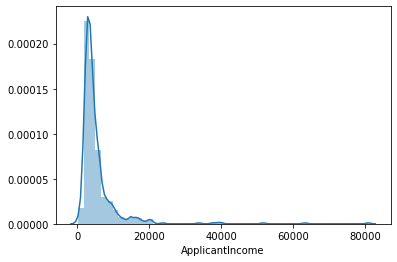

In [23]:
# 2. Applicant income very right skewed
sns.distplot(df['ApplicantIncome'])

In [26]:
print('ApplicantIncome mean',df['ApplicantIncome'].mean())
print('ApplicantIncome median',df['ApplicantIncome'].median())

ApplicantIncome mean 5403.459283387622
ApplicantIncome median 3812.5


<AxesSubplot:xlabel='CoapplicantIncome'>

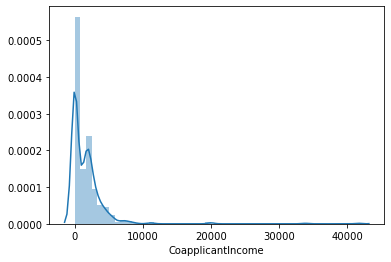

In [25]:
# 2. Coapplicant income also rightly skewed
sns.distplot(df['CoapplicantIncome'])

In [27]:
print('ApplicantIncome mean',df['CoapplicantIncome'].mean())
print('ApplicantIncome median',df['CoapplicantIncome'].median())

ApplicantIncome mean 1621.245798027101
ApplicantIncome median 1188.5


In [ ]:
# Both ApplicantIncome and CoapplicantIncome are rightly skewed as shown by the larger mean income vs the median

Let's discuss nominal (categorical) variable. Look at the number of unique values in each of them.

In [35]:
categorical.isna().sum()

Gender           13
Married           3
Dependents       15
Education         0
Self_Employed    32
Property_Area     0
Loan_Status       0
dtype: int64

In [36]:
categorical = df.select_dtypes('O').drop('Loan_ID', axis=1)

print('Number of unique values in each column (NaN values taken into consideration)')
for col in categorical.columns:
    if col in ['Gender', 'Married', 'Dependents', 'Self_Employed']:
        print(f'{col}:', categorical[col].unique().shape[0]-1)
    else:
        print(f'{col}:', categorical[col].unique().shape[0])
    

Number of unique values in each column (NaN values taken into consideration)
Gender: 2
Married: 2
Dependents: 4
Education: 2
Self_Employed: 2
Property_Area: 3
Loan_Status: 2


Explore further using the frequency of different categories in each nominal variable. Exclude the ID obvious reasons.

In [48]:
categorical = df.select_dtypes('O').drop('Loan_ID', axis=1)

for col in categorical.columns:
    print(col)
    print(categorical[col].value_counts())
    print('\n')

Gender
Male      489
Female    112
Name: Gender, dtype: int64


Married
Yes    398
No     213
Name: Married, dtype: int64


Dependents
0     345
1     102
2     101
3+     51
Name: Dependents, dtype: int64


Education
Graduate        480
Not Graduate    134
Name: Education, dtype: int64


Self_Employed
No     500
Yes     82
Name: Self_Employed, dtype: int64


Property_Area
Semiurban    233
Urban        202
Rural        179
Name: Property_Area, dtype: int64


Loan_Status
Y    422
N    192
Name: Loan_Status, dtype: int64




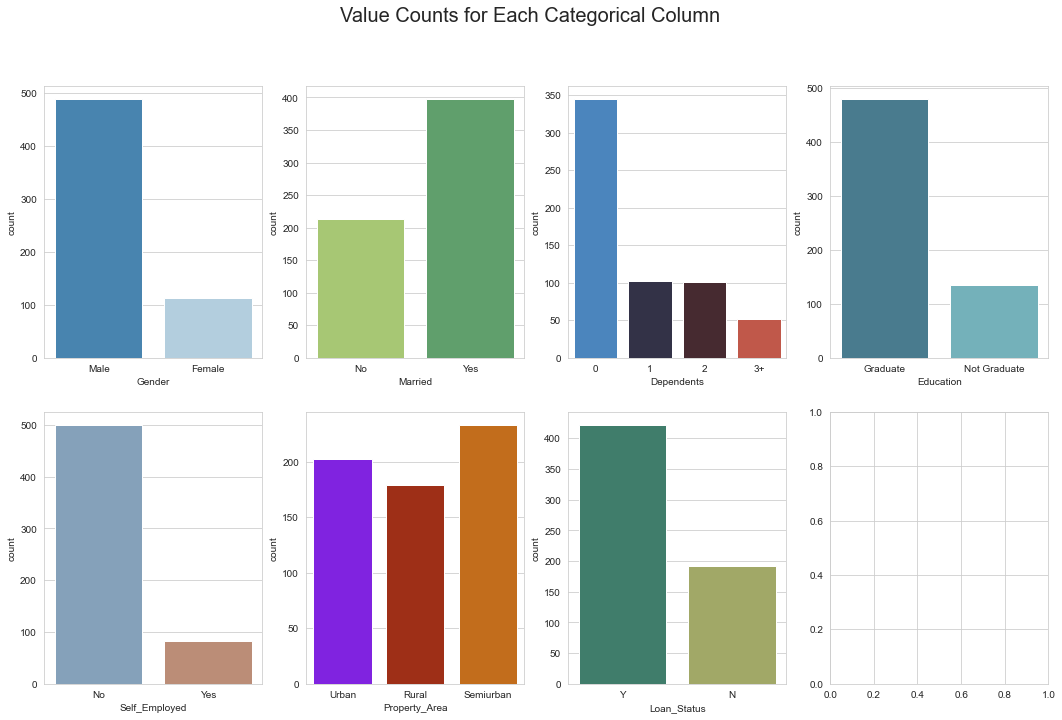

In [77]:
fig, axes = plt.subplots(2,4, figsize=(18, 11))
sns.set_style("whitegrid")
 
fig.suptitle('Value Counts for Each Categorical Column', fontsize=20)
sns.countplot(x='Gender', data=categorical, palette='Blues_r', ax=axes[0,0])
sns.countplot(x='Married', data=categorical, palette='summer_r', ax=axes[0,1])
sns.countplot(x='Dependents', data=categorical, palette='icefire', ax=axes[0,2])
sns.countplot(x='Education', data=categorical, palette='GnBu_d', ax=axes[0,3])
sns.countplot(x='Self_Employed', data=categorical, palette='twilight_shifted', ax=axes[1,0])
sns.countplot(x='Property_Area', data=categorical, palette='gnuplot', ax=axes[1,1])
sns.countplot(x='Loan_Status', data=categorical, palette='gist_earth', ax=axes[1,2]);

### Distribution analysis

Study distribution of various variables. Plot the histogram of ApplicantIncome, try different number of bins.



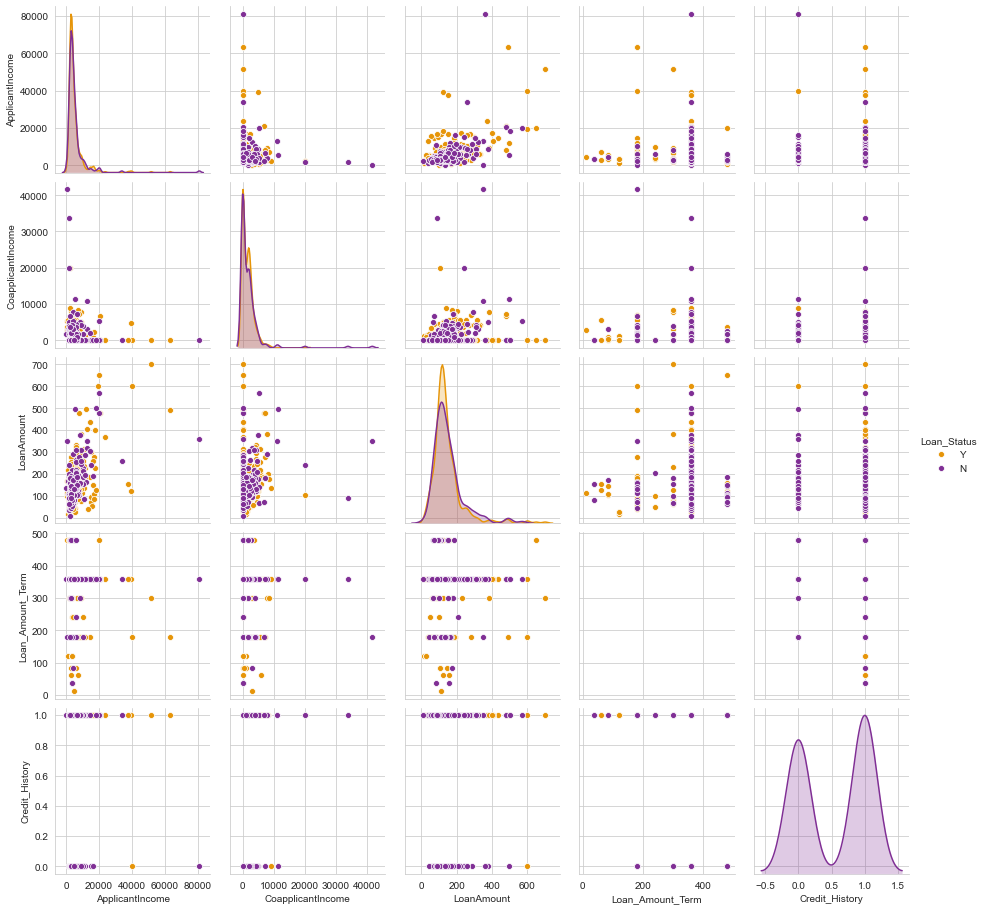

In [38]:
sns.set_style('whitegrid')
sns.pairplot(df, hue='Loan_Status', palette='CMRmap_r');

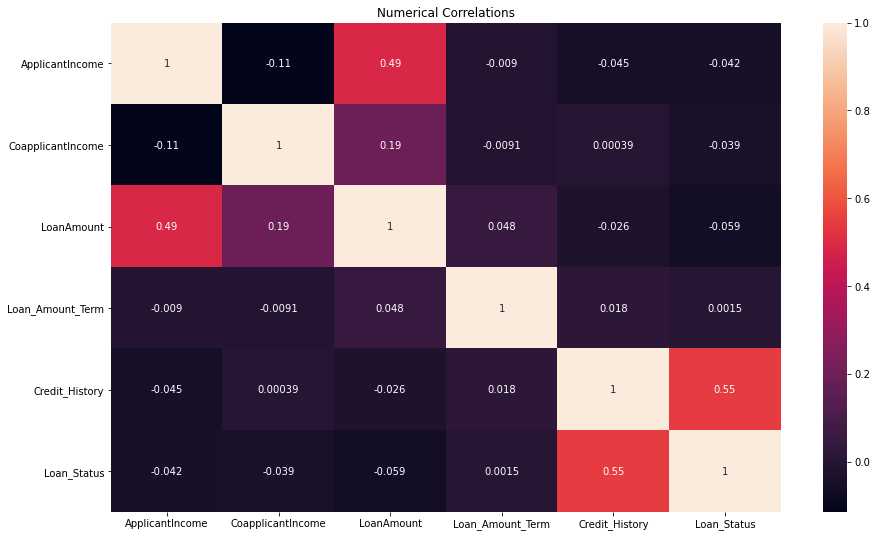

In [26]:
plt.figure(figsize=(15,9))

df_hm = df.copy()
df_hm['Loan_Status'] = df_hm['Loan_Status'].map({'Y': 1, 'N': 0})

sns.heatmap(df_hm.corr(), annot=True).set_title('Numerical Correlations');

# Correlations between
    # Loan Amount and ApplicantIncome
    # Credit History and Loan Status


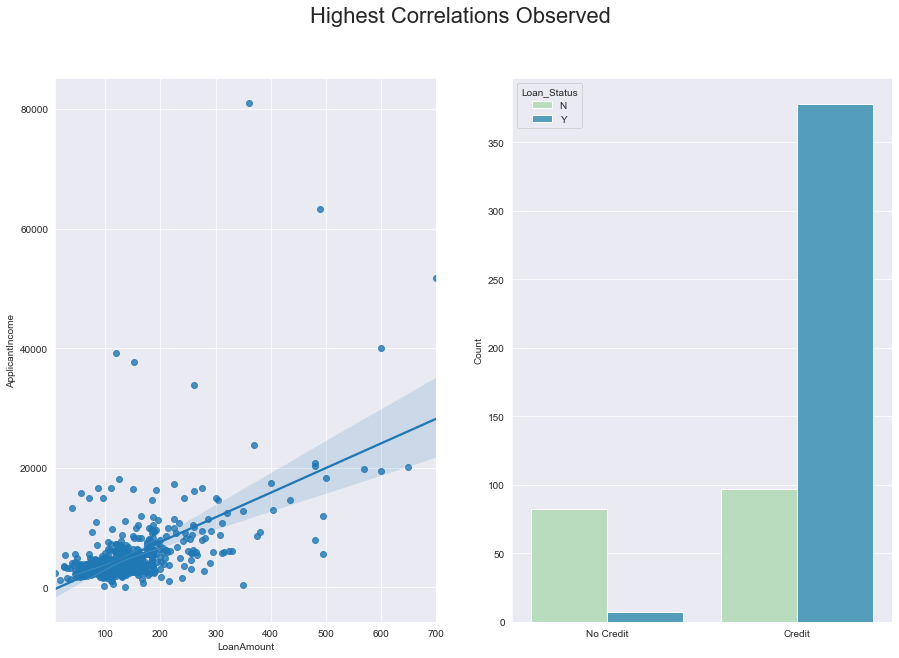

In [8]:
credit_loan = pd.DataFrame(df.groupby(['Loan_Status', 'Credit_History'])['Loan_Status'].count().reset_index(name='Count'))
credit_loan['Credit_History'] = credit_loan['Credit_History'].map({0.0: 'No Credit', 1.0: 'Credit'})

# Replace credit history vs loanstatus as second plot
fig, axes = plt.subplots(1,2, figsize=(15,10))
sns.set_style('darkgrid')


ax1 = sns.regplot(x='LoanAmount', y='ApplicantIncome',data=df, ax=axes[0]);
ax2 = sns.barplot(x='Credit_History', y='Count', hue='Loan_Status', data=credit_loan, ax=axes[1], palette='GnBu');

ax2.set_xlabel('');

plt.suptitle('Highest Correlations Observed', fontsize=22);

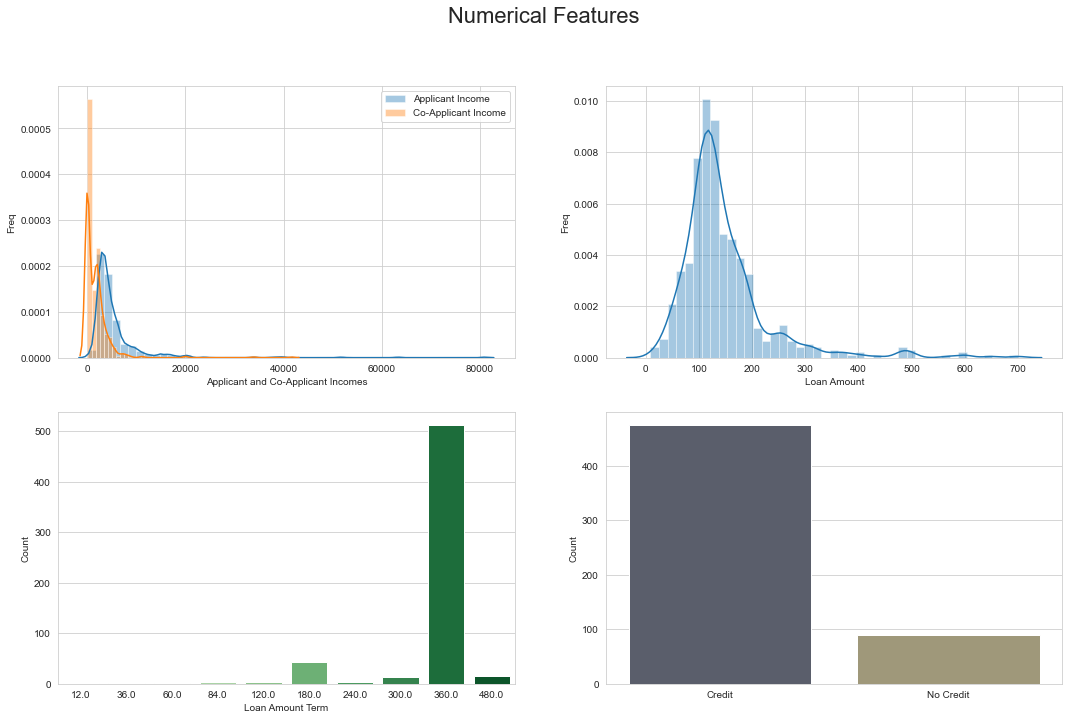

In [124]:
fig, axes = plt.subplots(2,2, figsize=(18, 11))
sns.set_style("whitegrid")

ax1 = sns.distplot(df['ApplicantIncome'], ax=axes[0,0], label='Applicant Income')
ax2 = sns.distplot(df['CoapplicantIncome'], ax=axes[0,0], label='Co-Applicant Income')
axes[0,0].set(ylabel='Freq', xlabel='Applicant and Co-Applicant Incomes')
ax1.legend();


ax3 = sns.distplot(df['LoanAmount'], ax=axes[0,1])
ax3.set(ylabel='Freq',xlabel='Loan Amount')

ax4 = sns.barplot(x=df['Loan_Amount_Term'].value_counts().index, 
                  y=df['Loan_Amount_Term'].value_counts().values, 
                  ax=axes[1,0], 
                  palette='Greens')
ax4.set(xlabel='Loan Amount Term', ylabel='Count')


ax5 = sns.barplot(x=df['Credit_History'].map({1.0: 'Credit', 0.0:'No Credit'}).value_counts().index, 
                  y=df['Credit_History'].map({1.0: 'Credit', 0.0:'No Credit'}).value_counts().values,
                  ax=axes[1,1], 
                  palette='cividis')
ax5.set(ylabel='Count');


plt.suptitle('Numerical Features', fontsize=22);


Look at the distribution of income segregated  by `Education`

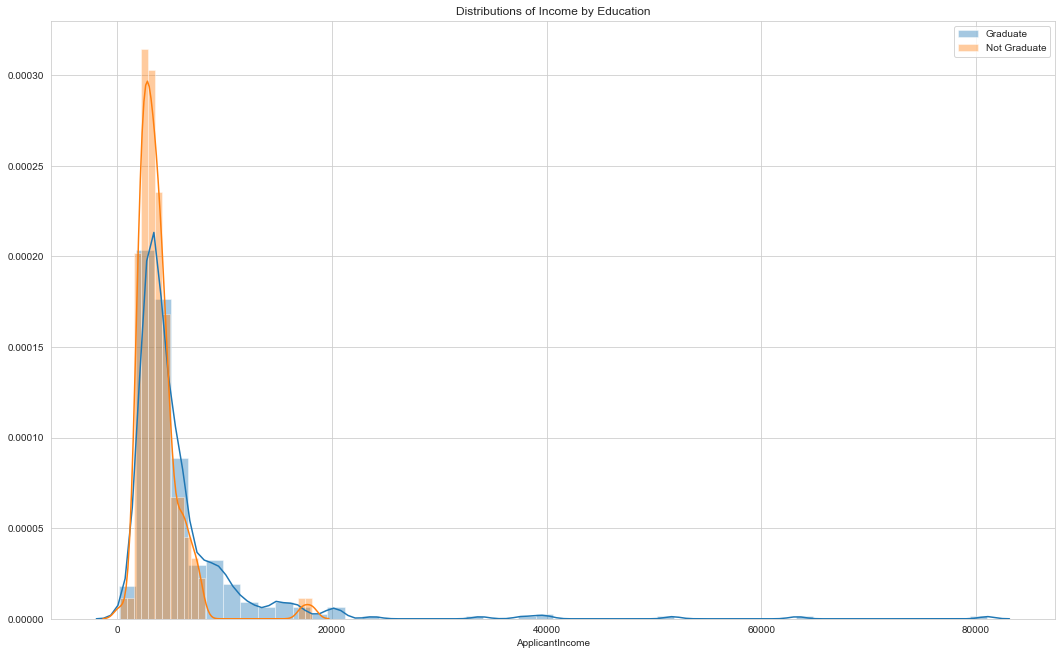

In [39]:
fig, axes = plt.subplots(figsize=(18, 11))
sns.set_style('whitegrid')

sns.distplot(df.loc[df['Education'] == 'Graduate', 'ApplicantIncome'], label='Graduate')
sns.distplot(df.loc[df['Education'] == 'Not Graduate', 'ApplicantIncome'], label= 'Not Graduate')

plt.legend();

plt.title('Distributions of Income by Education');

# the disribution leans more to the right and there are higher income outliers for graduates then non graduates
# Higher income potential for graduates then non graduates

Look at the histogram and boxplot of LoanAmount

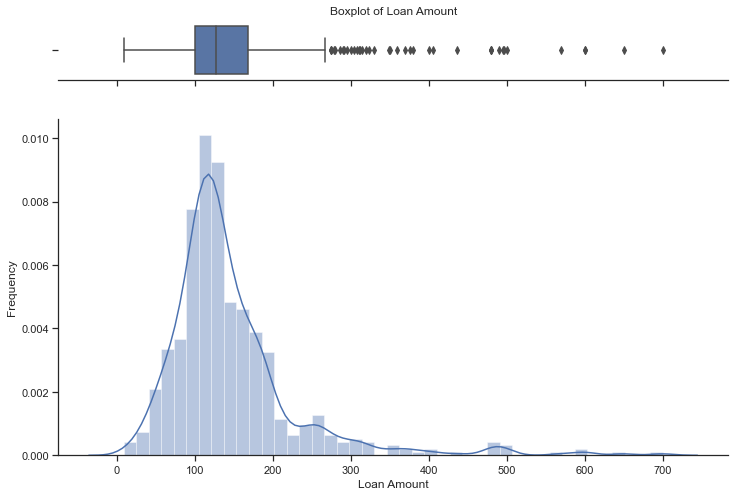

In [67]:
sns.set(style="ticks")

f, (ax_box, ax_hist) = plt.subplots(2, sharex=True, 
                                    gridspec_kw={"height_ratios": (.15, .85)}, figsize=(12,8))

sns.boxplot(df['LoanAmount'].values, ax=ax_box)
sns.distplot(df['LoanAmount'].values, ax=ax_hist)

sns.despine(ax=ax_hist)
sns.despine(ax=ax_box, left=True)

plt.xlabel('Loan Amount')
plt.ylabel('Frequency')

ax_box.set(title='Boxplot of Loan Amount');

## Feature importance for loan status


#### Is there a difference in loan approvals rates between men and women?

In [4]:
print('Proportion of Loan Approvals Overall: ', f"{round(df.loc[df['Loan_Status'] == 'Y'].shape[0]/df.shape[0], 3)*100}%")
print('Proportion of Loan Approvals by Female: ',f"{round(df.loc[(df['Gender'] == 'Female') & (df['Loan_Status'] == 'Y')].shape[0]/df.loc[df['Gender'] == 'Female'].shape[0], 3)*100}%")
print('Proportion of Loan Approvals by Male', f"{round(df.loc[(df['Gender'] == 'Male') & (df['Loan_Status'] == 'Y')].shape[0]/df.loc[df['Gender'] == 'Male'].shape[0], 3)*100}%")

Proportion of Loan Approvals Overall:  68.7%
Proportion of Loan Approvals by Female:  67.0%
Proportion of Loan Approvals by Male 69.3%


In [71]:
# null hypothesis: Pm_approved - Pf_approved = 0
# alt hypothesis: pm_approved != Pf_approved

gs = df[['Gender', 'Loan_Status']]

# Creating lists
prop_male_approved = []
prop_female_approved = []


# loop to be run 5000 times (200 samples each)
for i in range(5000):
    # Take 200 random samples
    sample = gs.sample(200)
    
    # (num of males approved loan)/(total number of males)
    male_approved_proportion=sample.loc[(sample['Gender'] == 'Male') & (sample['Loan_Status'] == 'Y')].shape[0]/ sample.loc[(sample['Gender'] == 'Male')].shape[0]
    # append
    prop_male_approved.append(male_approved_proportion)
    
    
    
    # (num of females approved loan)/(total number of females)
    female_approved_proportion=sample.loc[(sample['Gender'] == 'Female') & (sample['Loan_Status'] == 'Y')].shape[0]/ sample.loc[(sample['Gender'] == 'Female')].shape[0]
    # append
    prop_female_approved.append(female_approved_proportion)
    
    
    

# create new array with by finding difference between prop_male_approved and prop_female_approved
gender_proportion_difference = np.array(prop_male_approved) - np.array(prop_female_approved)

# 0 falls within +/- 2 standard devations from this gender_proportion_difference then there is no statistical difference
if (0 <= (gender_proportion_difference.mean() + gender_proportion_difference.std()*2)) and  (0 >= (gender_proportion_difference.mean() - gender_proportion_difference.std()*2)):
    print('No statistical difference between the loan approval rate between men and women')
else:
    print('There is a statistical difference between male and female approval loans')
    
    


No statistical difference between the loan approval rate between men and women


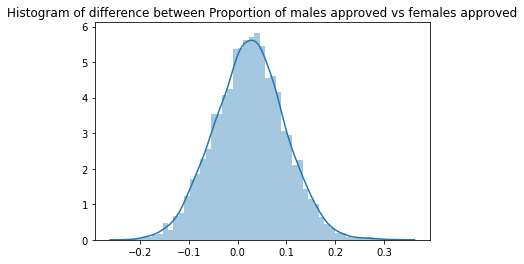

In [72]:
ax = sns.distplot(gender_proportion_difference)
ax.set_title('Histogram of Difference between Proportion of males approved vs females approved');


# There isnt strong enough evidence within this dataset to say there is a difference in loan approval rates between men and women

#### EDA Loan Approval Status

In [14]:
df['total_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']
df.pivot_table(index='Loan_Status', columns='Credit_History', values='total_income', aggfunc='mean').round(1)


# Within the loan approved group, we see that applicants with credit hx have a lower income then those with no credit hx

# When there is no credit hx, total income seems to correlate with loan approval status (higher income, greater chance of loan approval)
# That pattern is not seen with the credit hx group


# So for credit hx group, there are more factors at play (why was the higher income group be denied loans?)

Credit_History,0.0,1.0
Loan_Status,,
N,6877.6,7400.4
Y,11252.0,6840.4


In [15]:
df['total_income'] = df['ApplicantIncome'] + df['CoapplicantIncome']

df.pivot_table(index='Loan_Status', columns=['Credit_History', 'Married'], values='total_income', aggfunc='mean').round(1)

# Those with no credit hx and are loan approved have a higher income then those not approved, (married or not)
# This patter follows the same as above (higher income might correlate with loan status when no credit hx)


# For credit hx group, same pattern observed above.
# Those with loan approval have a lower avg income then those not loan approved (married not married)


# Marrige doesnt seem to play an important factor
# More factors in play when there is a credit hx (Why are higher income people w/ credit hx being denied for loans?)

Credit_History     0.0              1.0        
Married             No      Yes      No     Yes
Loan_Status                                    
N               5448.6   7659.5  6679.7  8024.0
Y               6985.7  14451.8  6026.9  7237.3

In [20]:
df.pivot_table(index='Loan_Status', 
               columns=['Self_Employed', 'Credit_History'], 
               values='total_income', aggfunc='median').round(1)

# Note: There are no approved loans where the applicant is self employed with no credit history
# https://clovermortgage.ca/self-employed-mortgage/
# Most lenders require a borrower to submit documentation detailing their income, net worth, 
# credit score, and much more. Self employed individuals do not get a T4 outlining their annual 
# income so they must provide the lender with a Stated Income Application that most of the 
# conventional banks will not accept


# When comparing groupwise, self employed applicants seem to make more on average then non self employed. (buisness owners, freelances)


# Also, we see that there is a higher threshold of income for loan approval in the self employed group
# vs the non self empolyed group
# The median income value (7121.5) for the self employed group w/ credit hx is higher then the non self employed group (5188)
# Seems that banks have stricter requirements for self employed people then non self employed even tho both groups have credit hx
# For the self employed, w/credit but still not approved loan (6000), their income was alot higher
# than the income of non-self employed people w/credit that were approved (5188)

# They require self employed applicants income to make more money in order for loan approval


# https://www.money.co.uk/loans/what-loans-can-you-apply-for-when-youre-self-employed.htm
# Banks and lenders have become more stringent about who they lend to. 
# This has made more difficult for those who are self-employed to get loans as their income can fluctuate month to month.




# Self_employment is a possible negative correlated predictor for Loan_Status approval. 
# Banks require a higher income for self employed people to get loan approval

# If the person is self employed but with no credit history, from the data there is no possibility they will be loan approved

Self_Employed       No             Yes        
Credit_History     0.0     1.0     0.0     1.0
Loan_Status                                   
N               5049.0  4939.0  6556.0  6000.0
Y               6144.0  5188.0     NaN  7121.5

In [8]:
dfencoded = df.copy()

dfencoded["Gender"] = dfencoded["Gender"].replace(["Female","Male"], [0, 1])
dfencoded["Married"] = dfencoded["Married"].replace(["No","Yes"], [0, 1])
dfencoded["Dependents"] = dfencoded["Dependents"].replace(["0","1","2","3+"], [0, 1,2,3])
dfencoded["Education"] = dfencoded["Education"].replace(["Not Graduate","Graduate"], [0, 1])
dfencoded["Self_Employed"] = dfencoded["Self_Employed"].replace(["No","Yes"], [0, 1])
dfencoded["Loan_Status"] = dfencoded["Loan_Status"].replace(["N","Y"], [0, 1])
dfencoded["Property_Area"] = dfencoded["Property_Area"].replace(["Rural","Semiurban", "Urban"], [0, 1, 2])

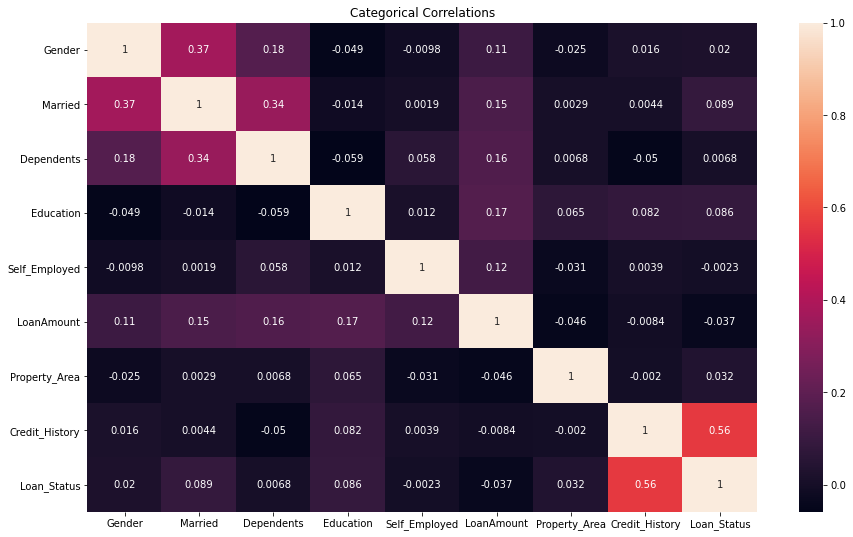

In [9]:
plt.figure(figsize=(15,9))

ax = sns.heatmap(
    dfencoded[["Gender", "Married", "Dependents",  "Education", "Self_Employed", 'LoanAmount',"Property_Area", "Credit_History", "Loan_Status", ]].corr(), 
    annot=True);

ax.set(title='Categorical Correlations');

# Correlation with those married and having dependents
# Again Credit history and Loan status have high correlation
# Married and Education also have minor correlations with LoanStatus

#### Ratio of total income vs loan amount

In [24]:
# total_income/LoanAmount
# Smaller the values means that that group was asking for a larger loan amount compared to their income
# vice versa

pd.DataFrame(df.groupby(['Loan_Status', 'Credit_History'])['total_income'].mean()/
             df.groupby(['Loan_Status', 'Credit_History'])['LoanAmount'].mean()).rename({0:'total_income/LoanAmount'}, axis=1).round(2)


# Cut off proportion value is 54 for Loan Approval when no credit.
# Cut off proportion value is 48 for loan approval with credit.
# Those with credit history could ask for a larger loan amounts compared to their total income and still be approved
# vs Those without a credit history (less leniency in larger loan amounts lent when no credit hx)
# Banks will trust/lend you with more money if you have a credit hx vs if you dont compared with your total income

# These ratios are important for determining loan approval

# Possible feature engineering idea?

total_income/LoanAmount
Loan_Status Credit_History                         
N           0.0                               48.65
            1.0                               47.56
Y           0.0                               54.55
            1.0                               48.14

In [4]:
# Those live in rural areas asked for higher loan amounts compared to semi-urban/urban
# Possibly farming
# Lower income people might be in more debt, therefore ask for higher loan amounts

df.pivot_table(index='Loan_Status', columns='Property_Area', values='LoanAmount')

Property_Area,Rural,Semiurban,Urban
Loan_Status,,,
N,158.742424,154.566038,140.354839
Y,148.261682,142.760000,143.085271


#### LoanAmount vs Genders

In [27]:
# Males Generally asked for higher loan amounts then females

# Males without credit history ask for a higher loan amount then males with a credit history
# This same pattern wasnt seen with females

df.pivot_table(index=['Credit_History'], columns='Gender', values='LoanAmount', aggfunc='mean')

Gender,Female,Male
Credit_History,,
0.0,124.375000,153.045455
1.0,126.439024,146.520436


In [25]:
# When comparing proportion of total_income/LoanAmount
# Smaller values indicate that that group was asking for a larger loan compared to their income

# Females with no credit hx group asked for the largest loans compared to their income
# Females generally asked for larger loan amounts compared to their income comparitivly to males

df.pivot_table(index=['Credit_History'], columns='Gender', values='total_income', aggfunc='mean')/df.pivot_table(index=['Credit_History'], columns='Gender', values='LoanAmount', aggfunc='mean')

Gender,Female,Male
Credit_History,,
0.0,39.725687,51.458142
1.0,44.607517,48.200983


In [ ]:
# What could make the model more robust is the debt score per applicant

## 3. Data Cleaning

This step typically involves imputing missing values and treating outliers. 

### Imputing Missing Values

Missing values may not always be NaNs. For instance, the `Loan_Amount_Term` might be 0, which does not make sense.



In [10]:
df = pd.read_csv('./data.csv')

### Extreme values
Try a log transformation to get rid of the extreme values in `LoanAmount`. Plot the histogram before and after the transformation

<AxesSubplot:xlabel='LoanAmount'>

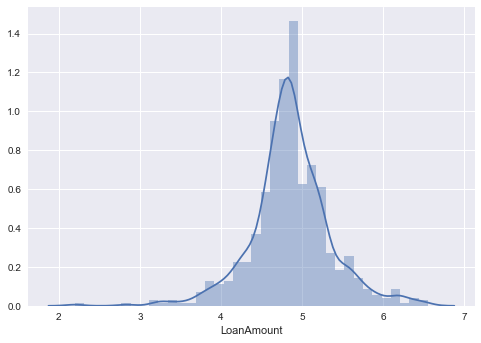

In [63]:
sns.distplot(np.log(df['LoanAmount']))

<AxesSubplot:xlabel='LoanAmount'>

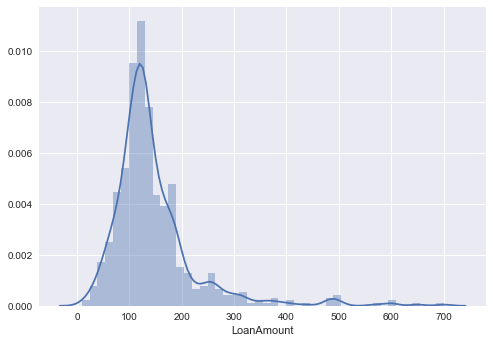

In [64]:
sns.distplot(df['LoanAmount'])

Combine both incomes as total income and take a log transformation of the same.

In [70]:
df.columns

Index(['Loan_ID', 'Gender', 'Married', 'Dependents', 'Education',
       'Self_Employed', 'ApplicantIncome', 'CoapplicantIncome', 'LoanAmount',
       'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'Loan_Status'],
      dtype='object')

<AxesSubplot:xlabel='log_total_income'>

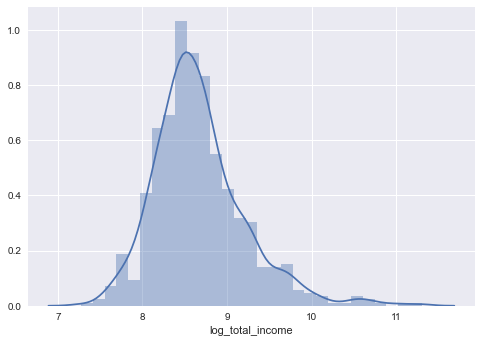

In [66]:
# df['log_total_income'] = np.log(df['ApplicantIncome'] + df['CoapplicantIncome'])
# sns.distplot(df['log_total_income'])

## 4. Building a Predictive Model

1. Keep things simple. Not risking adding noise to my data and reducing my metrics due to too much feature engineering. See what my metrics would be by keeping feature engineering to a minimal. If not improving then I would start feature engineering.


2. Which do I want to focus Precision or Recall (from a banks perspective)?

* High precision, low recall scenario: Banks would have very strict requirements for loan approval. The loan approval rate would be low due to the stringent nature of the requirements.This is good as there would be a greater chance for the customers who are approved, to pay off their loans and thus minimizing the banks cost loss. The downfall of this scenario is that the banks would potentially lose revenue from interest payments due to small customer market.


* Low precision, high recall scenario: The opposite as above. Stringent requirements are relaxed and more people are approved for loans. This could potentially increase revenue for banks but also increase risk of defaulted loan payments and thus losing money.


* Therefore the best metric to track is F1 score: We want to improve both precision and recall. We want to approve loans at a rate where we optmize revenue while minimizing loss from default payments. 


In [71]:
# Filled empties with either mode or median of that column

df = pd.read_csv('./data.csv')
df.drop('Loan_ID', axis=1, inplace=True)
df['Gender'].fillna('Male', inplace=True)
df['Married'].fillna('No', inplace=True)
df['Dependents'].fillna('0', inplace=True)
df['Self_Employed'].fillna('No', inplace=True)
df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)

df['Loan_Amount_Term'].fillna(360, inplace=True)
df['Loan_Amount_Term'].map({0: 360})

df['Credit_History'].fillna(0.0, inplace=True)

X,y = df.drop('Loan_Status', axis=1), df['Loan_Status']


In [2]:
# precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix

def get_scores(ytrue, ypreds):
    acc = accuracy_score(ytrue, ypreds)
    precision = precision_score(ytrue, ypreds)
    recall = recall_score(ytrue, ypreds)
    f1 = f1_score(ytrue, ypreds)
    
    print('Accuracy: ', round(acc, 3))
    print('Precision: ', round(precision, 3))
    print('Recall: ', round(recall, 3))
    print('F1: ', round(f1, 3))
    print(confusion_matrix(ytrue, ypreds))
    print('\n')

#### Running with no log transformations; OHE categorical columns and Standard scaling numerical inputs

In [90]:
df.shape

(614, 13)

In [74]:
# Running with no log transformations
# OHE categorical columns and Standard scaling numerical inputs



ohe_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']
stdsclr_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(), ohe_columns),
                                     ('stdsclar', StandardScaler(), stdsclr_columns)], remainder='passthrough')

X_transformed = ct.fit_transform(X)
xtrain,xtest,ytrain,ytest=train_test_split(X_transformed, y, test_size = 0.2)



rf = RandomForestClassifier()
xg = XGBClassifier()
ab = AdaBoostClassifier()
lr = LogisticRegression()



rf.fit(xtrain, ytrain)
print('Random Forest')
get_scores(ytest, rf.predict(xtest))

xg.fit(xtrain, ytrain)
print('XGBoost')
get_scores(ytest, xg.predict(xtest))

ab.fit(xtrain, ytrain)
print('Adaboost')
get_scores(ytest, ab.predict(xtest))

lr.fit(xtrain, ytrain)
print('Logistic Regression')
get_scores(ytest, lr.predict(xtest))

Random Forest
Accuracy:  0.715
Precision:  0.767
Recall:  0.815
F1:  0.79
[[22 20]
 [15 66]]


XGBoost
Accuracy:  0.707
Precision:  0.747
Recall:  0.84
F1:  0.791
[[19 23]
 [13 68]]


Adaboost
Accuracy:  0.724
Precision:  0.753
Recall:  0.864
F1:  0.805
[[19 23]
 [11 70]]


Logistic Regression
Accuracy:  0.789
Precision:  0.789
Recall:  0.926
F1:  0.852
[[22 20]
 [ 6 75]]




#### Taking LOG(loan amount) and LOG(applicantIncome + coapplicantIncome) and LOG(Loan_Amount_Term); OHE columns

In [64]:
# Taking log of loan amount and LOG(applicantIncome + coapplicantIncome) and Loan_Amount_Term
# OHE columns

X['LoanAmount'] = np.log(X['LoanAmount'])
X['log_total_income'] = np.log(X['CoapplicantIncome'] + X['ApplicantIncome'])
X['Loan_Amount_Term'] = np.log(X['Loan_Amount_Term'])

X.drop(['CoapplicantIncome', 'ApplicantIncome'], axis=1)

ohe_columns = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area', 'Credit_History']


ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(), ohe_columns)], remainder='passthrough')

X_transformed = ct.fit_transform(X)
xtrain,xtest,ytrain,ytest=train_test_split(X_transformed, y, test_size = 0.2)


rf = RandomForestClassifier()
xg = XGBClassifier()
ab = AdaBoostClassifier()
lr = LogisticRegression()

rf.fit(xtrain, ytrain)
print('Random Forest')
get_scores(ytest, rf.predict(xtest))

xg.fit(xtrain, ytrain)
print('XGBoost')
get_scores(ytest, xg.predict(xtest))

ab.fit(xtrain, ytrain)
print('Adaboost')
get_scores(ytest, ab.predict(xtest))

lr.fit(xtrain, ytrain)
print('Logistic Regression')
get_scores(ytest, lr.predict(xtest))

Random Forest
Accuracy:  0.683
Precision:  0.728
Recall:  0.827
F1:  0.775
[[17 25]
 [14 67]]


XGBoost
Accuracy:  0.699
Precision:  0.762
Recall:  0.79
F1:  0.776
[[22 20]
 [17 64]]


Adaboost
Accuracy:  0.732
Precision:  0.779
Recall:  0.827
F1:  0.802
[[23 19]
 [14 67]]


Logistic Regression
Accuracy:  0.74
Precision:  0.763
Recall:  0.877
F1:  0.816
[[20 22]
 [10 71]]




In [1]:
# Worse performance after log scaling

#### Label Encoding all columns except Property_Area (OHE) and standard scaled continious numerical columns

* Gender: male=1, female=0
* married: yes=1, no=0
* Dependents, 0, 1, 2, 3
* Self_Employed: Yes=1, no=0
* Education: Graduate=1, Not graduate=0
* Property Area: OneHotEncode


In [92]:
df.head()

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


In [114]:
df = pd.read_csv("./data.csv") 
df.drop('Loan_ID', axis=1, inplace=True)
X, y = df.drop('Loan_Status', axis=1), df['Loan_Status']

In [115]:
# Fill NaNs
X['Gender'].fillna('Male', inplace=True)
X['Married'].fillna('No', inplace=True)
X['Dependents'].fillna('0', inplace=True)
X['Self_Employed'].fillna('No', inplace=True)
X['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
X['Loan_Amount_Term'].fillna(360, inplace=True)
X['Loan_Amount_Term'].map({0: 360})
X['Credit_History'].fillna(0.0, inplace=True)


# Label encode with numbers
X['Gender'] = X['Gender'].map({'Male':1, 'Female':0})
X['Married'] = X['Married'].map({'No':0, 'Yes': 1})
X['Dependents'] = X['Dependents'].map({'0': 0, '1': 1, '2': 2, '3+': 4})
X['Self_Employed'] = X['Self_Employed'].map({'No': 0, 'Yes': 1})
X['Education'] = X['Education'].map({'Graduate': 1, 'Not Graduate': 0})

In [116]:
ohe_columns = ['Property_Area']
stdsclr_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']

ct = ColumnTransformer(transformers=[('ohe', OneHotEncoder(), ohe_columns),
                                     ('stdsclar', StandardScaler(), stdsclr_columns)], remainder='passthrough')

X_transformed = ct.fit_transform(X)
X_transformed.shape

(614, 13)

In [9]:
xtrain,xtest,ytrain,ytest=train_test_split(X_transformed, y, test_size = 0.2)

rf = RandomForestClassifier()
xg = XGBClassifier()
ab = AdaBoostClassifier()
lr = LogisticRegression()

rf.fit(xtrain, ytrain)
print('Random Forest')
get_scores(ytest, rf.predict(xtest))

xg.fit(xtrain, ytrain)
print('XGBoost')
get_scores(ytest, xg.predict(xtest))

ab.fit(xtrain, ytrain)
print('Adaboost')
get_scores(ytest, ab.predict(xtest))

lr.fit(xtrain, ytrain)
print('Logistic Regression')
get_scores(ytest, lr.predict(xtest))

Random Forest
Accuracy:  0.748
Precision:  0.726
Recall:  0.932
F1:  0.817
[[23 26]
 [ 5 69]]


XGBoost
Accuracy:  0.732
Precision:  0.711
Recall:  0.932
F1:  0.807
[[21 28]
 [ 5 69]]


Adaboost
Accuracy:  0.691
Precision:  0.684
Recall:  0.905
F1:  0.779
[[18 31]
 [ 7 67]]


Logistic Regression
Accuracy:  0.732
Precision:  0.703
Recall:  0.959
F1:  0.811
[[19 30]
 [ 3 71]]




#### Label Encoded, No Standard Scaling

In [105]:
df = pd.read_csv("./data.csv") 
df.drop('Loan_ID', axis=1, inplace=True)

#Drop null values in all the categorical columns
df = df.dropna(subset = ["Gender","Married","Dependents","Education","Self_Employed","Credit_History","Property_Area"])


#Fill null values in columns with continous data with the mean of each column
df["LoanAmount"] = df["LoanAmount"].fillna(data["LoanAmount"].mean())
df["Loan_Amount_Term"] = df["Loan_Amount_Term"].fillna(data["Loan_Amount_Term"].mean())
df.isnull().sum()

df["Gender"] = df["Gender"].replace(["Female","Male"], [0, 1])
df["Married"] = df["Married"].replace(["No","Yes"], [0, 1])
df["Dependents"] = df["Dependents"].replace(["0","1","2","3+"], [0, 1,2,3])
df["Education"] = df["Education"].replace(["Not Graduate","Graduate"], [0, 1])
df["Self_Employed"] = df["Self_Employed"].replace(["No","Yes"], [0, 1])
df["Loan_Status"] = df["Loan_Status"].replace(["N","Y"], [0, 1])
df["Property_Area"] = df["Property_Area"].replace(["Rural","Semiurban", "Urban"], [0, 1, 2])



xtrain, xtest, ytrain,ytest=train_test_split(df.drop('Loan_Status', axis=1), df['Loan_Status'], test_size=0.2)


rf = RandomForestClassifier()
xg = XGBClassifier()
ab = AdaBoostClassifier()
lr = LogisticRegression()

rf.fit(xtrain, ytrain)
print('Random Forest')
get_scores(ytest, rf.predict(xtest))

xg.fit(xtrain, ytrain)
print('XGBoost')
get_scores(ytest, xg.predict(xtest))

ab.fit(xtrain, ytrain)
print('Adaboost')
get_scores(ytest, ab.predict(xtest))

lr.fit(xtrain, ytrain)
print('Logistic Regression')
get_scores(ytest, lr.predict(xtest))

Random Forest
Accuracy:  0.835
Precision:  0.844
Recall:  0.962
F1:  0.899
[[10 14]
 [ 3 76]]


XGBoost
Accuracy:  0.786
Precision:  0.82
Recall:  0.924
F1:  0.869
[[ 8 16]
 [ 6 73]]


Adaboost
Accuracy:  0.777
Precision:  0.826
Recall:  0.899
F1:  0.861
[[ 9 15]
 [ 8 71]]


Logistic Regression
Accuracy:  0.816
Precision:  0.819
Recall:  0.975
F1:  0.89
[[ 7 17]
 [ 2 77]]




## Label Encoded categorical columns,  standard scaling 

In [90]:
df = pd.read_csv("./data.csv") 
df.drop('Loan_ID', axis=1, inplace=True)



#Drop null values in all the categorical columns
df = data.dropna(subset = ["Gender","Married","Dependents","Education","Self_Employed","Credit_History","Property_Area"])


#Fill null values in columns with continous data with the mean of each column
df["LoanAmount"] = data["LoanAmount"].fillna(data["LoanAmount"].mean())
df["Loan_Amount_Term"] = data["Loan_Amount_Term"].fillna(data["Loan_Amount_Term"].mean())

df["Gender"] = df["Gender"].replace(["Female","Male"], [0, 1])
df["Married"] = df["Married"].replace(["No","Yes"], [0, 1])
df["Dependents"] = df["Dependents"].replace(["0","1","2","3+"], [0,1,2,3])
df["Education"] = df["Education"].replace(["Not Graduate","Graduate"], [0, 1])
df["Self_Employed"] = df["Self_Employed"].replace(["No","Yes"], [0, 1])
df["Loan_Status"] = df["Loan_Status"].replace(["N","Y"], [0, 1])
df["Property_Area"] = df["Property_Area"].replace(["Rural","Semiurban", "Urban"], [0, 1, 2])


stdsclr_columns = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
ct = ColumnTransformer(transformers=[('stdsclar', StandardScaler(), stdsclr_columns)], remainder='passthrough')

X, y = df.drop('Loan_Status', axis=1), df['Loan_Status']

X_transformed = ct.fit_transform(X)

xtrain, xtest, ytrain,ytest=train_test_split(X_transformed, y, test_size=0.2)


rf = RandomForestClassifier()
xg = XGBClassifier()
ab = AdaBoostClassifier()
lr = LogisticRegression()

rf.fit(xtrain, ytrain)
print('Random Forest')
get_scores(ytest, rf.predict(xtest))

xg.fit(xtrain, ytrain)
print('XGBoost')
get_scores(ytest, xg.predict(xtest))

ab.fit(xtrain, ytrain)
print('Adaboost')
get_scores(ytest, ab.predict(xtest))

lr.fit(xtrain, ytrain)
print('Logistic Regression')
get_scores(ytest, lr.predict(xtest))

Random Forest
Accuracy:  0.893
Precision:  0.867
Recall:  1.0
F1:  0.929
[[20 11]
 [ 0 72]]


XGBoost
Accuracy:  0.874
Precision:  0.855
Recall:  0.986
F1:  0.916
[[19 12]
 [ 1 71]]


Adaboost
Accuracy:  0.816
Precision:  0.844
Recall:  0.903
F1:  0.872
[[19 12]
 [ 7 65]]


Logistic Regression
Accuracy:  0.874
Precision:  0.847
Recall:  1.0
F1:  0.917
[[18 13]
 [ 0 72]]




### RandomizedSearchCV

In [110]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}


grid = RandomizedSearchCV(estimator=RandomForestClassifier(), param_distributions=random_grid, cv=3, n_jobs=-1, verbose=2, n_iter=1000)

grid.fit(X_transformed, y)

print(grid.best_score_)
print(grid.best_estimator_)

Fitting 3 folds for each of 1000 candidates, totalling 3000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:    8.2s
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed:   37.5s
[Parallel(n_jobs=-1)]: Done 349 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 632 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 997 tasks      | elapsed:  4.2min
[Parallel(n_jobs=-1)]: Done 1442 tasks      | elapsed:  6.0min
[Parallel(n_jobs=-1)]: Done 1969 tasks      | elapsed:  8.4min
[Parallel(n_jobs=-1)]: Done 2576 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 3000 out of 3000 | elapsed: 12.9min finished


0.8062607499140007
RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=600)


In [76]:
rf = RandomForestClassifier(max_depth=80, max_features='sqrt', min_samples_leaf=4,
                       min_samples_split=10, n_estimators=600)

xtrain, xtest, ytrain,ytest=train_test_split(X_transformed, y, test_size=0.2)

rf.fit(xtrain, ytrain)
print('Random Forest')
get_scores(ytest, rf.predict(xtest))

Random Forest
Accuracy:  0.864
Precision:  0.841
Recall:  1.0
F1:  0.914
[[15 14]
 [ 0 74]]




#### Preprocessing Features

In [2]:
df.drop('Loan_ID', axis=1, inplace=True)

df.dropna(subset = ["Gender","Married","Dependents","Education","Self_Employed","Credit_History","Property_Area"], inplace=True)

# fill empty numerical values with median
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())

X, y = df.drop('Loan_Status', axis=1), df['Loan_Status']
y = y.replace(['Y','N'], [1, 0])

categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', ]

transformers = [('cat', OrdinalEncoder(), categorical_cols), 
                ('num', StandardScaler(), numerical_cols)]

ct = ColumnTransformer(transformers=transformers, remainder='passthrough')

X_transformed = ct.fit_transform(X)

### Bayesian Hyperparameter Optimization

In [13]:
from hyperopt import hp,fmin,tpe,STATUS_OK,Trials
from sklearn.model_selection import cross_val_score

xtrain, xtest, ytrain, ytest = train_test_split(X_transformed, y, test_size=0.3)


space = {'criterion': hp.choice('criterion', ['entropy', 'gini']),
        'max_depth': hp.quniform('max_depth', 10, 1200, 10),
        'max_features': hp.choice('max_features', ['auto', 'sqrt','log2', None]),
        'min_samples_leaf': hp.uniform('min_samples_leaf', 0, 0.5),
        'min_samples_split' : hp.uniform ('min_samples_split', 0, 1),
        'n_estimators' : hp.choice('n_estimators', [10, 50, 300, 750, 1200,1300,1500])
        }


def objective(space):
    model = RandomForestClassifier(criterion = space['criterion'], max_depth = space['max_depth'],
                                 max_features = space['max_features'],
                                 min_samples_leaf = space['min_samples_leaf'],
                                 min_samples_split = space['min_samples_split'],
                                 n_estimators = space['n_estimators'], 
                                 )
    
    accuracy = cross_val_score(model, xtrain, ytrain, cv = 10).mean()

    return {'loss': -accuracy, 'status': STATUS_OK }


trials = Trials()
best = fmin(fn= objective,
            space= space,
            algo= tpe.suggest,
            max_evals = 20,
            trials= trials)

crit = {0: 'entropy', 1: 'gini'}
feat = {0: 'auto', 1: 'sqrt', 2: 'log2', 3: None}
est = {0: 10, 1: 50, 2: 300, 3: 750, 4: 1200,5:1300,6:1500}


print(crit[best['criterion']])
print(feat[best['max_features']])
print(est[best['n_estimators']])


trainedforest = RandomForestClassifier(criterion = crit[best['criterion']], max_depth = best['max_depth'], 
                                       max_features = feat[best['max_features']], 
                                       min_samples_leaf = best['min_samples_leaf'], 
                                       min_samples_split = best['min_samples_split'], 
                                       n_estimators = est[best['n_estimators']]).fit(xtrain, ytrain)

ypreds = trainedforest.predict(xtest)

get_scores(ytest, ypreds)








# RandomForestClassifier(criterion='entropy', max_depth=500.0, max_features=None,
#                        min_samples_leaf=0.037384061767347265,
#                        min_samples_split=0.30190050123847756, n_estimators=750)

100%|███████████████████████████████████████████████| 20/20 [01:26<00:00,  4.34s/trial, best loss: -0.7843896713615024]
gini
None
1500
Accuracy:  0.864
Precision:  0.841
Recall:  0.991
F1:  0.91
[[ 27  20]
 [  1 106]]




### TPOT
1. https://towardsdatascience.com/tpot-automated-machine-learning-in-python-4c063b3e5de9
2.  http://epistasislab.github.io/tpot/using/




* An automated machine learning (autoML) tool in Python.
* TPOT has what its developers call a genetic search algorithm to find the best parameters and model ensembles.
* This power of TPOT comes from evaluating all kinds of possible pipelines automatically and efficiently. Doing this manually is cumbersome and slower.


Broadly speaking, Genetic Algorithms have three properties:

1. Selection: You have a population of possible solutions to a given problem and a fitness function. At every iteration, you evaluate how to fit each solution with your fitness function.
2. Crossover: Then you select the fittest ones and perform crossover to create a new population.
3. Mutation: You take those children and mutate them with some random modification and repeat the process until you get the fittest or best solution.

In [14]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt','log2']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 1000,10)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10,14]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4,6,8]
# Create the random grid
param = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
              'criterion':['entropy','gini']}

tp_clf = TPOTClassifier(generations= 5, population_size= 24, offspring_size= 12, # 1440
                                 verbosity= 2, early_stop= 12,
                                 config_dict={'sklearn.ensemble.RandomForestClassifier': param}, 
                                 cv = 5, scoring = 'accuracy')
tp_clf.fit(xtrain, ytrain)

ypreds = tp_clf.predict(xtest)
get_scores(ytest, ypreds)


# Score were same, but perhaps I didnt run it long enough


Generation 1 - Current best internal CV score: 0.7843632958801499
Generation 2 - Current best internal CV score: 0.7843632958801499
Generation 3 - Current best internal CV score: 0.7843632958801499
Generation 4 - Current best internal CV score: 0.7843632958801499
Generation 5 - Current best internal CV score: 0.7843632958801499
Best pipeline: RandomForestClassifier(input_matrix, criterion=gini, max_depth=450, max_features=sqrt, min_samples_leaf=8, min_samples_split=14, n_estimators=1200)
Accuracy:  0.864
Precision:  0.841
Recall:  0.991
F1:  0.91
[[ 27  20]
 [  1 106]]




In [2]:
# Now Label encoding categorical columns and Standard scaling continious numerical columns

## 5. Using Pipeline
If you didn't use pipelines before, transform your data prep, feat. engineering and modeling steps into Pipeline. It will be helpful for deployment.

The goal here is to create the pipeline that will take one row of our dataset and predict the probability of being granted a loan.

`pipeline.predict(x)`

In [177]:
# df.drop('Loan_ID', axis=1, inplace=True)

# drop rows with missing values
df.dropna(subset = ["Gender","Married","Dependents","Education","Self_Employed","Credit_History","Property_Area"], inplace=True)

# fill empty numerical values with median
df['LoanAmount'] = df['LoanAmount'].fillna(df['LoanAmount'].median())
df['Loan_Amount_Term'] = df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].median())

X, y = df.drop('Loan_Status', axis=1), df['Loan_Status']
y = y.replace(['Y','N'], [1, 0])

categorical_cols = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']
numerical_cols = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term', ]

transformers = [('cat', OrdinalEncoder(), categorical_cols), 
                ('num', StandardScaler(), numerical_cols)]

ct = ColumnTransformer(transformers=transformers, remainder='passthrough')


xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2)


# Use the presets for the Bayesian hyperparameter optimization (cross validated)
rf_bayesian_hypopt = RandomForestClassifier(criterion='entropy', max_depth=500.0, max_features=None,
                       min_samples_leaf=0.037384061767347265,
                       min_samples_split=0.30190050123847756, n_estimators=750)


rf_pipe = Pipeline([('feature tranform', ct),
                    ('RandomForest', rf_bayesian_hypopt)])

rf_pipe.fit(xtrain, ytrain)

ypreds = rf_pipe.predict(xtest)
get_scores(ytest, ypreds)

Accuracy:  0.913
Precision:  0.899
Recall:  1.0
F1:  0.947
[[14  9]
 [ 0 80]]




#### Final Model score using pipeline

### ROC Curve

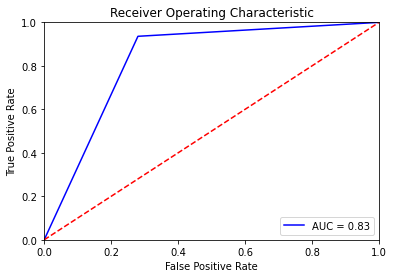

In [166]:
import matplotlib.pyplot as plt

fpr, tpr, threshold = roc_curve(ytest, ypreds)
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

## 6. Deploy your model to cloud and test it with PostMan, BASH or Python

In [25]:
import pickle

filename = 'model1.sav'
pickle.dump(rf_pipe, open(filename, 'wb'))

In [26]:
loaded_model = pickle.load(open(filename, 'rb'))

In [27]:
loaded_model.predict_proba(pd.DataFrame([xtrain.iloc[0].values], columns=xtrain.columns))

array([[0.044, 0.956]])

In [6]:
df.loc[df['Loan_Status'] == 'Y'][1:3]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y


In [7]:
df.loc[df['Loan_Status'] == 'N'][:2]

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
7,LP001014,Male,Yes,3+,Graduate,No,3036,2504.0,158.0,360.0,0.0,Semiurban,N


In [1]:
df = pd.read_csv('./data.csv')

In [5]:
x = df.groupby(['Dependents', 'Loan_Status'])['Gender'].count().reset_index().rename({'Gender': 'Totals'}, axis=1)
d = x.groupby('Dependents')['Totals'].sum().reset_index().rename({'Totals': 'total_by_dependent'}, axis=1)
final = pd.merge(left=x, right=d, on='Dependents')
final['Percents_by_Dependents'] = final['Totals']/final['total_by_dependent']
final.drop(['total_by_dependent'], axis=1, inplace=True)
final

,Dependents,Loan_Status,Totals,Percents_by_Dependents
0,0,N,104,0.307692
1,0,Y,234,0.692308
2,1,N,36,0.356436
3,1,Y,65,0.643564
4,2,N,23,0.232323
5,2,Y,76,0.767677
6,3+,N,18,0.375000
7,3+,Y,30,0.625000


In [217]:
x = df.groupby(['Dependents', 'Loan_Status'])['Gender'].count().reset_index().rename({'Gender': 'Totals'}, axis=1)
d = x.groupby('Dependents')['Totals'].sum().reset_index().rename({'Totals': 'total_by_dependent'}, axis=1)
final = pd.merge(left=x, right=d, on='Dependents')
final['Percents_by_Dependents'] = final['Totals']/final['total_by_dependent']
final.drop(['total_by_dependent'], axis=1, inplace=True)

,Dependents,Loan_Status,Totals,Percents_by_Dependents
0,0,N,104,0.307692
1,0,Y,234,0.692308
2,1,N,36,0.356436
3,1,Y,65,0.643564
4,2,N,23,0.232323
5,2,Y,76,0.767677
6,3+,N,18,0.375000
7,3+,Y,30,0.625000


In [10]:
x =      {'Gender':'Male', 
                'Married': 'Yes', 
                            'Dependents': '0', 
                            'Education': 'Graduate', 
                            'Self_Employed': 'Yes', 
                            'ApplicantIncome': 5849, 
                            'CoapplicantIncome': 0, 
                            'LoanAmount': 128, 
                            'Loan_Amount_Term': 360.0, 
                            'Credit_History': 1.0, 
                            'Property_Area': 'Rural'}


x

{'Gender': 'Male',
 'Married': 'Yes',
 'Dependents': '0',
 'Education': 'Graduate',
 'Self_Employed': 'Yes',
 'ApplicantIncome': 5849,
 'CoapplicantIncome': 0,
 'LoanAmount': 128,
 'Loan_Amount_Term': 360.0,
 'Credit_History': 1.0,
 'Property_Area': 'Rural'}

In [15]:
pd.DataFrame([x.values()], columns=x.keys())

,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,Male,Yes,0,Graduate,Yes,5849,0,128,360.0,1.0,Rural
